# Market Sentiment

In [ ]:
!pip3 install -r requirements.txt

In [2]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from fredapi import Fred
import yfinance as yf
from datetime import datetime

In [3]:
# Fred API Key - https://fredaccount.stlouisfed.org/apikey
FRED_API_KEY = '09596556559446cc85ebc36072f84ebd'

## CNN fear and greed gauge

- https://edition.cnn.com/markets/fear-and-greed
- https://www.investopedia.com/terms/f/fear-and-greed-index.asp

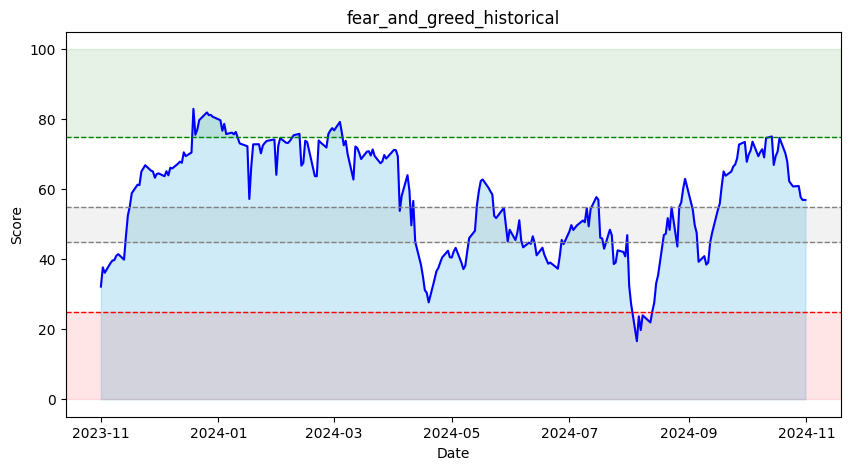

In [ ]:
def cnn(feature: str, thresholds):

    # Step 1: Set up headers for a recent Google Chrome browser
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36'
    }

    # Step 2: Retrieve JSON data with headers
    url = 'https://production.dataviz.cnn.io/index/fearandgreed/graphdata'
    response = requests.get(url, headers=headers)
    data = response.json()

    # Step 3: Extract feature data
    historical_data = data[feature]['data']
    timestamps = [entry['x'] / 1000 for entry in historical_data]  # Convert from ms to seconds
    scores = [entry['y'] for entry in historical_data]
    ratings = [entry['rating'] for entry in historical_data]

    # Step 4: Convert timestamps to readable dates
    dates = [datetime.fromtimestamp(ts) for ts in timestamps]

    # Step 5: Create a DataFrame for easier manipulation
    df = pd.DataFrame({
        'Date': dates,
        'Score': scores,
        'Rating': ratings
    })

    # Step 6: Plot with shaded areas
    plt.figure(figsize=(10, 5))

    # Plot the feature line
    plt.plot(df['Date'], df['Score'], color='blue', label='Score')

    # Fill between 0 and score
    plt.fill_between(df['Date'], 0, df['Score'], color='skyblue', alpha=0.4)

    if isinstance(thresholds, list) and (len(thresholds) == 4 or len(thresholds) == 6):
        # Add shaded red area (extreme fear)
        plt.axhspan(thresholds[0], thresholds[1], color='red', alpha=0.1)
        plt.axhline(thresholds[1], color='red', linestyle='--', linewidth=1)

        # Add shaded grey area (neutral)
        if (len(thresholds) == 6):
            plt.axhspan(thresholds[2], thresholds[3], color='grey', alpha=0.1)
            plt.axhline(thresholds[2], color='grey', linestyle='--', linewidth=1)
            plt.axhline(thresholds[3], color='grey', linestyle='--', linewidth=1)

        # Add shaded green area (extreme greed)
        plt.axhspan(thresholds[-2], thresholds[-1], color='green', alpha=0.1)
        plt.axhline(thresholds[-2], color='green', linestyle='--', linewidth=1)

    # Add titles and labels
    plt.title(feature)
    plt.xlabel('Date')
    plt.ylabel('Score')
    # plt.legend()
    plt.show()

cnn(feature='fear_and_greed_historical', thresholds=[0, 25, 45, 55, 75, 100])
cnn(feature='market_momentum_sp500', thresholds=[])
cnn(feature='market_momentum_sp125', thresholds=[])
cnn(feature='stock_price_strength', thresholds=[])
cnn(feature='stock_price_breadth', thresholds=[])
cnn(feature='put_call_options', thresholds=[])
cnn(feature='market_volatility_vix', thresholds=[])
cnn(feature='market_volatility_vix_50', thresholds=[])
cnn(feature='junk_bond_demand', thresholds=[])
cnn(feature='safe_haven_demand', thresholds=[])

Attempt at replicating the index:
- https://www.tradingview.com/pine/?id=PUB%3B0c7930ef401a44f3a4d01efc3c2a39c3

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

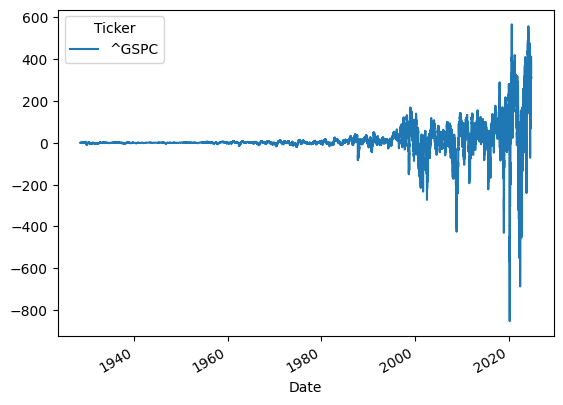

In [ ]:
# 1. Stock Price Momentum (relative to its moving average)
def momentum(data: pd.DataFrame, window: int=125):
    ma = data.rolling(window).mean()
    return (data - ma).dropna()

sp500 = yf.download('^GSPC', interval='1d', period='max')['Close']
momentum(sp500).plot()

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

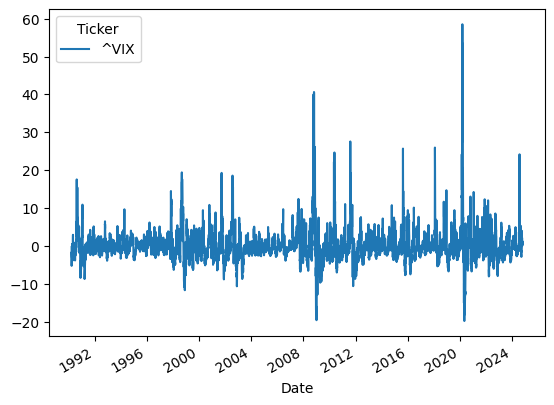

In [ ]:
# 5. Market Volatility (the VIX)
vix = yf.download('^VIX', interval='1d', period='max')['Close']
momentum(vix, 50).plot()

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['^NYH']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

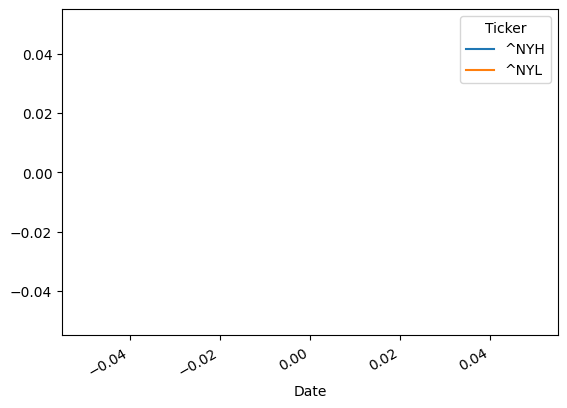

In [ ]:
def stock_price_strength():
    # Using NYSE new highs and new lows as proxies
    # Replace these with relevant data sources as needed
    nyse_highs = yf.download('^NYH', interval='1d', period='max')['Close']
    nyse_lows = yf.download('^NYL', interval='1d', period='max')['Close']
    return (nyse_highs - nyse_lows).dropna()

stock_price_strength().plot()

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['^PCRATIO']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['^JNK']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['^LQD']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['^NYH']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*************

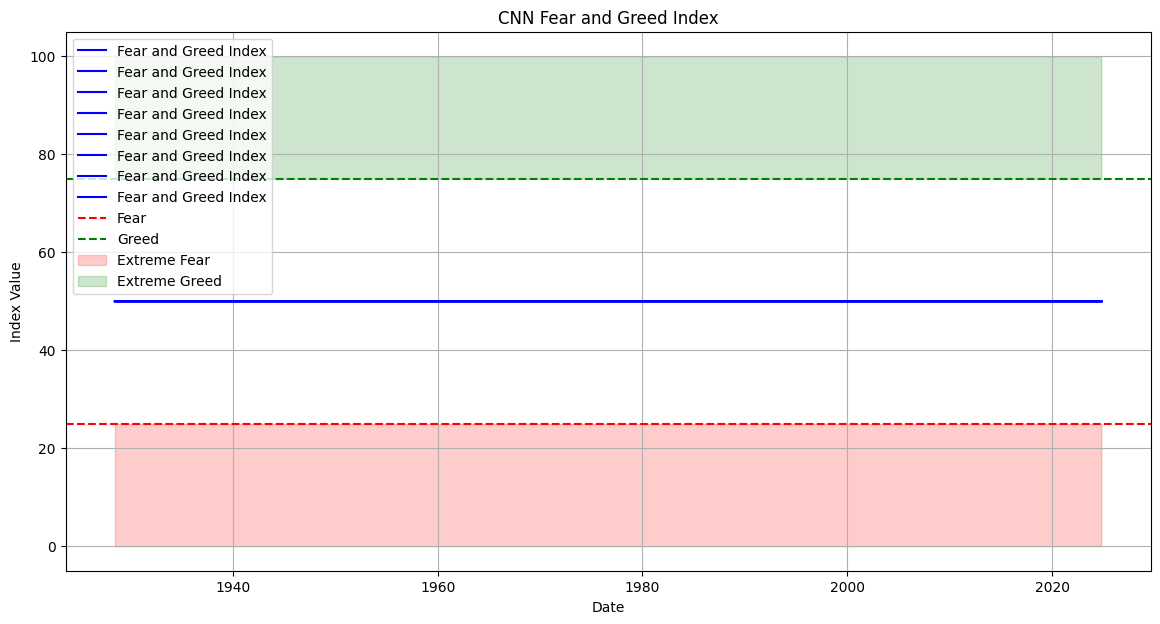

In [ ]:
# Define weights for each component of the Fear and Greed Index
momentum_weight = 1
strength_weight = 1
breadth_weight = 1
put_call_weight = 1
vix_weight = 1
safe_haven_weight = 1
junk_bond_weight = 1

# 1. Stock Price Momentum (S&P 500 relative to its 125-day moving average)
def spx_momentum():
    sp500 = yf.download('^GSPC', interval='1d', period='max')['Close']
    sp500_125MA = sp500.rolling(window=125).mean()
    return (sp500 - sp500_125MA).dropna()

# 2. Stock Price Strength (52-week highs vs lows approximation)
def stock_price_strength():
    # Using NYSE new highs and new lows as proxies
    # Replace these with relevant data sources as needed
    nyse_highs = yf.download('^NYH', interval='1d', period='max')['Close']
    nyse_lows = yf.download('^NYL', interval='1d', period='max')['Close']
    return (nyse_highs - nyse_lows).dropna()

# 3. Stock Price Breadth (proxy using McClellan Summation Index)
def mcclellan_sum_index():
    # Placeholder for McClellan Summation Index
    return pd.Series()  # Replace with actual McClellan Summation Index calculation

# 4. Put and Call Options (using Put/Call ratio)
put_call_ratio = yf.download('^PCRATIO', interval='1d', period='max')['Close'].rolling(window=5).mean().dropna()

# 5. Market Volatility (the VIX)
vix = yf.download('^VIX', interval='1d', period='max')['Close']
vix_50MA = vix.rolling(window=50).mean().dropna()

# 6. Safe Haven Demand (S&P 500 returns vs 10-Year Treasury returns)
sp500_returns = spx_momentum().pct_change(periods=20)
bond_yield = yf.download('^TNX', interval='1d', period='max')['Close'].pct_change(periods=20).dropna()
safe_haven_demand = (sp500_returns - bond_yield).dropna()

# 7. Junk Bond Demand (spread between high-yield and investment-grade bonds)
junk_yield = yf.download('^JNK', interval='1d', period='max')['Close']
investment_grade_yield = yf.download('^LQD', interval='1d', period='max')['Close']
junk_bond_demand = (junk_yield - investment_grade_yield).dropna()

# Normalize and scale each component
def normalize(series, length=25):
    min_val = series.rolling(window=length).min()
    max_val = series.rolling(window=length).max()
    return ((series - min_val) / (max_val - min_val) * 100).fillna(50)

# Calculate normalized components
momentum = normalize(spx_momentum())
strength = normalize(stock_price_strength())
breadth = normalize(mcclellan_sum_index())
put_call = normalize(put_call_ratio)
vix_normalized = normalize(vix_50MA)
safe_haven = normalize(safe_haven_demand)
junk_bond = normalize(junk_bond_demand)

# Calculate Fear and Greed Index
fear_greed_index = (momentum * momentum_weight + 
                    strength * strength_weight + 
                    breadth * breadth_weight + 
                    put_call * put_call_weight + 
                    vix_normalized * vix_weight + 
                    safe_haven * safe_haven_weight + 
                    junk_bond * junk_bond_weight) / (
                    momentum_weight + strength_weight + breadth_weight + 
                    put_call_weight + vix_weight + safe_haven_weight + junk_bond_weight)

# Normalize the Fear and Greed Index
fear_greed_index_normalized = normalize(fear_greed_index, 25)

# Plot the Fear and Greed Index
plt.figure(figsize=(14, 7))
plt.plot(fear_greed_index_normalized, label="Fear and Greed Index", color="blue")
plt.axhline(25, color="red", linestyle="--", label="Fear")
plt.axhline(75, color="green", linestyle="--", label="Greed")
plt.fill_between(fear_greed_index_normalized.index, 0, 25, color='red', alpha=0.2, label="Extreme Fear")
plt.fill_between(fear_greed_index_normalized.index, 75, 100, color='green', alpha=0.2, label="Extreme Greed")
plt.title("CNN Fear and Greed Index")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.legend()
plt.grid(True)
plt.show()

## Buffet Indicator

- https://www.currentmarketvaluation.com/models/buffett-indicator.php

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

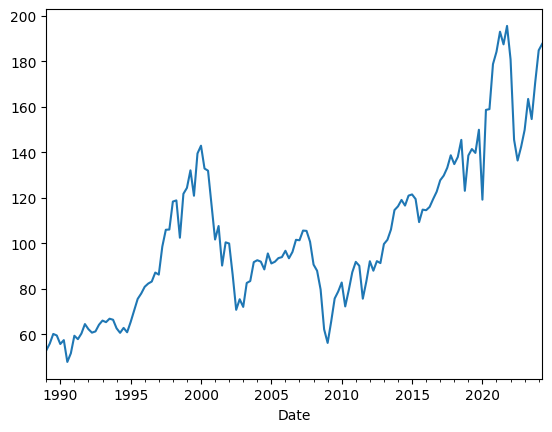

In [ ]:
# Initialize the FRED API with your API key
fred = Fred(api_key=FRED_API_KEY)

# Fetch U.S. GDP data from FRED
gdp = fred.get_series('GDP').dropna()
gdp.index.name = 'Date'
gdp = gdp.resample('QS').first().to_frame(name='GDP')

# Fetch Wilshire 5000 data from Yahoo Finance
wilshire_5000 = yf.download('^FTW5000', interval='3mo', period='max')['Adj Close']
wilshire_5000.index = wilshire_5000.index.tz_localize(None)
wilshire_5000 = wilshire_5000.resample('QS').first()

# Plot the Buffett Indicator
buffett_indicator = wilshire_5000['^FTW5000'] / gdp['GDP'] * 100
buffett_indicator = buffett_indicator.dropna()
buffett_indicator.plot()